imports 

In [1]:
import os
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import navpy
from gnssutils import EphemerisManager
from pykml.factory import KML_ElementMaker as KML
from lxml import etree

# Constants
WEEKSEC = 604800
LIGHTSPEED = 2.99792458e8
ECEF_THRESHOLD = 1e-3  # Convergence threshold for iterative least squares

# Paths
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')

# Ephemeris manager instance
manager = EphemerisManager(ephemeris_data_directory)


 Parse Log File and Process Timestamps


In [2]:
# Read log file and parse data
def parse_log_file(input_filepath):
    with open(input_filepath) as csvfile:
        reader = csv.reader(csvfile)
        android_fixes = []
        measurements = []
        for row in reader:
            if row[0][0] == '#':
                if 'Fix' in row[0]:
                    android_fixes = [row[1:]]
                elif 'Raw' in row[0]:
                    measurements = [row[1:]]
            else:
                if row[0] == 'Fix':
                    android_fixes.append(row[1:])
                elif 'Raw' in row[0]:
                    measurements.append(row[1:])
                    
    android_fixes_df = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
    measurements_df = pd.DataFrame(measurements[1:], columns = measurements[0])

    # Format satellite IDs
    measurements_df.loc[measurements_df['Svid'].str.len() == 1, 'Svid'] = '0' + measurements_df['Svid']
    measurements_df.loc[measurements_df['ConstellationType'] == '1', 'Constellation'] = 'G'
    measurements_df.loc[measurements_df['ConstellationType'] == '3', 'Constellation'] = 'R'
    measurements_df['SvName'] = measurements_df['Constellation'] + measurements_df['Svid']

    # Remove all non-GPS measurements
    measurements_df = measurements_df.loc[measurements_df['Constellation'] == 'G']

    # Convert columns to numeric representation
    numeric_cols = ['Cn0DbHz', 'TimeNanos', 'FullBiasNanos', 'ReceivedSvTimeNanos', 'PseudorangeRateMetersPerSecond', 'ReceivedSvTimeUncertaintyNanos']
    for col in numeric_cols:
        measurements_df[col] = pd.to_numeric(measurements_df[col])

    # Check for optional columns
    optional_cols = ['BiasNanos', 'TimeOffsetNanos']
    for col in optional_cols:
        if col not in measurements_df.columns:
            measurements_df[col] = 0
        else:
            measurements_df[col] = pd.to_numeric(measurements_df[col])

    return measurements_df, android_fixes_df

# Calculate GPS time and split data into epochs
def process_timestamps(measurements):
    measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
    gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
    measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc = True, origin=gpsepoch)

    # Split data into measurement epochs
    measurements['Epoch'] = 0
    measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
    measurements['Epoch'] = measurements['Epoch'].cumsum()

# Change the path to your GNSS log file
input_filepath = '/home/abodi-massarwa/gnss_repo/gnss-analysis/data/sample/boaz/Fixed/gnss_log_2024_04_13_19_51_17.txt'
measurements, android_fixes_df = parse_log_file(input_filepath)
process_timestamps(measurements)


Calculate Pseudoranges, Satellite Positions, and RMS Minimization

In [3]:
# Calculate pseudoranges
def calculate_pseudoranges(measurements):
    measurements['tRxGnssNanos'] = measurements['TimeNanos'] + measurements['TimeOffsetNanos'] - (measurements['FullBiasNanos'].iloc[0] + measurements['BiasNanos'].iloc[0])
    measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['tRxGnssNanos'] / WEEKSEC)
    measurements['tRxSeconds'] = 1e-9 * measurements['tRxGnssNanos'] - WEEKSEC * measurements['GpsWeekNumber']
    measurements['tTxSeconds'] = 1e-9 * (measurements['ReceivedSvTimeNanos'] + measurements['TimeOffsetNanos'])
    measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']
    measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
    measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

calculate_pseudoranges(measurements)

# Calculate satellite position
def calculate_satellite_position(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv'] = ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    delT_oc = transmit_time - ephemeris['t_oc']
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    return sv_position

# RMS minimization algorithm to calculate position
def rms_minimization(xs, measured_pseudorange, x0, b0):
    dx = 100 * np.ones(3)
    b = b0
    G = np.ones((measured_pseudorange.size, 4))
    iterations = 0

    while np.linalg.norm(dx) > ECEF_THRESHOLD and iterations < 100:
        r = np.linalg.norm(xs - x0, axis=1)
        phat = r + b0
        deltaP = measured_pseudorange - phat
        G[:, 0:3] = -(xs - x0) / r[:, None]
        sol = np.linalg.inv(np.transpose(G) @ G) @ np.transpose(G) @ deltaP
        dx = sol[0:3]
        db = sol[3]
        x0 = x0 + dx
        b0 = b0 + db
        iterations += 1

    rms = np.sqrt(np.mean(deltaP**2))
    return x0, b0, rms

# Processing epochs and calculating positions with RMS minimization
def process_epochs_rms(measurements):
    ecef_list = []
    rms_list = []
    for epoch in measurements['Epoch'].unique():
        one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)]
        one_epoch = one_epoch.drop_duplicates(subset='SvName').set_index('SvName')
        if len(one_epoch.index) > 4:
            timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
            sats = one_epoch.index.unique().tolist()
            ephemeris = manager.get_ephemeris(timestamp, sats)
            sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])

            xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()
            pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
            pr = pr.to_numpy()

            x, b, rms = rms_minimization(xs, pr, np.array([0, 0, 0]), 0)
            ecef_list.append(x)
            rms_list.append(rms)
    
    return np.stack(ecef_list, axis=0), rms_list

# Run the RMS minimization
ecef_array, rms_list = process_epochs_rms(measurements)


Save Results and Generate Outputs

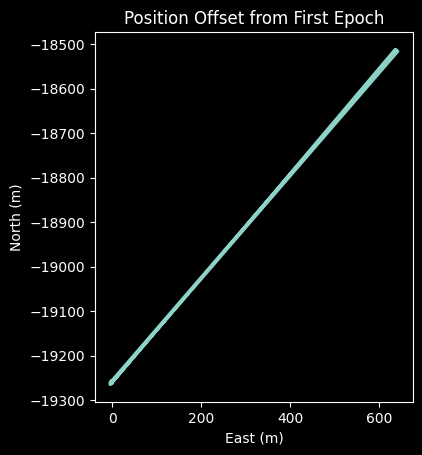

In [4]:
# Convert ECEF to LLA and save to CSV
def save_to_csv(ecef_array, android_fixes_df, output_csv):
    lla_array = np.stack(navpy.ecef2lla(ecef_array), axis=1)
    ref_lla = lla_array[0, :]
    ned_array = navpy.ecef2ned(ecef_array, ref_lla[0], ref_lla[1], ref_lla[2])

    lla_df = pd.DataFrame(lla_array, columns=['Latitude', 'Longitude', 'Altitude'])
    ned_df = pd.DataFrame(ned_array, columns=['N', 'E', 'D'])

    lla_df.to_csv(output_csv, index=False)
    android_fixes_df.to_csv('android_position.csv', index=False)

    plt.style.use('dark_background')
    plt.plot(ned_df['E'], ned_df['N'])
    plt.title('Position Offset from First Epoch')
    plt.xlabel("East (m)")
    plt.ylabel("North (m)")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Create KML file from positions
def create_kml_file(lla_array, output_kml):
    doc = KML.kml(
        KML.Document(
            KML.name("GNSS Path"),
            KML.Style(
                KML.LineStyle(
                    KML.color("ff0000ff"),
                    KML.width(2)
                ),
                id="redLine"
            ),
            KML.Placemark(
                KML.name("GNSS Path"),
                KML.styleUrl("#redLine"),
                KML.LineString(
                    KML.extrude(1),
                    KML.tessellate(1),
                    KML.altitudeMode("absolute"),
                    KML.coordinates(" ".join([f"{lon},{lat},{alt}" for lat, lon, alt in lla_array]))
                )
            )
        )
    )

    with open(output_kml, 'wb') as f:
        f.write(etree.tostring(doc, pretty_print=True))

# Main function to process the GNSS log file and generate outputs
def main():
    input_filepath = '/home/abodi-massarwa/gnss_repo/gnss-analysis/data/sample/boaz/Fixed/gnss_log_2024_04_13_19_51_17.txt'  # Change this to your GNSS log file path
    output_csv = '/home/abodi-massarwa/gnss_repo/gnss-analysis/data/output_parsed_files/csv/calculated_position.csv'
    output_kml = '/home/abodi-massarwa/gnss_repo/gnss-analysis/data/output_parsed_files/kml/calculated_path.kml'

    measurements, android_fixes_df = parse_log_file(input_filepath)
    process_timestamps(measurements)
    calculate_pseudoranges(measurements)
    ecef_array, rms_list = process_epochs_rms(measurements)
    save_to_csv(ecef_array, android_fixes_df, output_csv)
    lla_array = np.stack(navpy.ecef2lla(ecef_array), axis=1)
    create_kml_file(lla_array, output_kml)

if __name__ == '__main__':
    main()
